In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from nltk.text import Text
from wordcloud import WordCloud, STOPWORDS

# ! [ -e /content ] && pip install -Uqq fastai  # uncomment to upgrade fastai on colab
from fastai_ulmfit.pretrained import *
# !pip install fastai_ulmfit
from fastai.text.all import *
from fastai.data.core import DataLoaders

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.html.use_mathjax', False) # removes italisized values

# fellowship.ai Challenge Problem - Text Classification On AG News

### By Logan Larson

As Jeremy Howard discusses in his introductory chapter to *Deep Learning for Coders with fastai and PyTorch*, transfer learning is the most important method we have to allow us to train more accurate models, more quickly, with less data, time and money. However, he goes on to say that "the importance of pretrained models is generally not recognized or discussed in most courses, books, or software library features, and is rarely considered in academic papers. As we write this at the start of 2020, things are just starting to change, but it's likely to take a while."

In an effort to bridge my own divide between knowing how important transfer learning is (and will likely continue to become) but not knowing how to go about using it effectively, I'm using this opportunity to explore pretrained models in the context of performing text classification on AG News, which I believe was at least partly selected by fellowship.ai as a challenge problem due to how differently one has to think and approach NLP problems compared to other domains, like computer vision or tabular modeling. Whereas computer vision tasks use images as inputs and tabular modeling uses many structured fields to help make predictions, NLP problems largely work with raw (and often messy) blobs of text. 

To work with these blobs of text, I need to be aware of one big "gotcha" in this domain: Not all characters in a blob of text are created equally. To that end, I need to be aware the options I have to preprocess my data. While I don't want to remove anything from the text that could contribute to its meaning, I do want to get rid of anything that doesn't provide value - like any Javascript code or new-line characters that only make computations harder. Other things to consider include reduction operations like lemmatization, which reduces a word into it's root word.

## My Approach

1. Understand the problem
1. Decide on a metric
1. Create simple baseline model
1. Create baseline language model
1. Train model with ULMFiT methodology
1. Retrain model with ULMFiT methodology after basic data cleaning
1. Next steps

## 1. Understand the Problem

The prompt given was "Perform Text classification on AG News. Do a thorough Exploratory Data Analysis of the dataset and report the final performance metrics for your approach. Suggest ways in which you can improve the model."

More specifically, I know from the README file packaged with this dataset that I'm working with tabular data containing features that correspond to an article's title, its description, and its class index, which is an integer between 1 and 4 that maps to one of four categories (World, Sports, Business, Sci/Tech). While it doesn't say which category maps to which integer, we can take an educated guess by loading the data and finding the most frequent words in each class. 

In [76]:
raw_train_df = pd.read_csv('train.csv', names=['class', 'title', 'description'], engine='python')
raw_test_df = pd.read_csv('test.csv', names=['class', 'title', 'description'], engine='python')
raw_train_df.head(2)

,class,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."


Before we go any further, let's make sure there weren't any issues with loading the data. Per the README file, we are expecting 30,000 rows per class in the training set and 1,900 per class in the test set. There is no reason to think we should have any null values in any of our features.

In [15]:
raw_train_df[['class','title']].groupby('class').count()

,title
class,
1,30000
2,30000
3,30000
4,30000


In [16]:
raw_test_df[['class','title']].groupby('class').count()

,title
class,
1,1900
2,1900
3,1900
4,1900


In [17]:
raw_train_df.isnull().sum(axis = 0)

class          0
title          0
description    0
dtype: int64

In [18]:
raw_test_df.isnull().sum(axis = 0)

class          0
title          0
description    0
dtype: int64

As it looks like the data were loaded properly, we can move on to figuring out which class is which by visualizing the most common words in each training class.

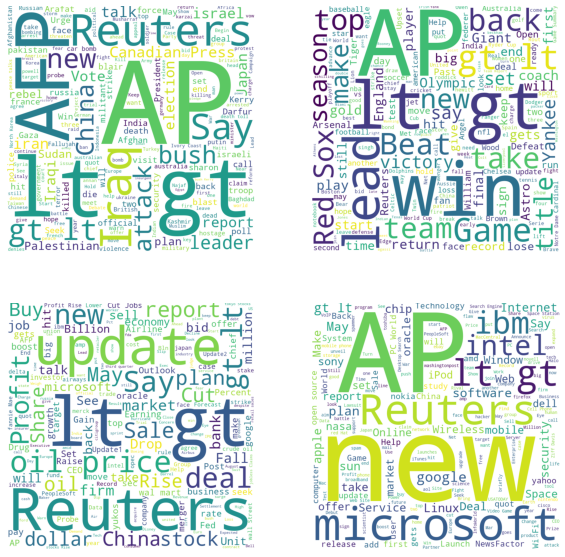

In [22]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
stopwords = STOPWORDS
for row in list(range(2)):
    for col in list(range(2)):
        dep_var = row * 2 + col + 1
        df = raw_train_df[raw_train_df['class'] == dep_var]
        comment_words = ''
        for val in df['title']:
            # tokenize
            val = str(val)
            tokens = val.split()
            tokens2 = [word.lower() for word in tokens if len(word.strip()) > 2]
            comment_words += " ".join(tokens2)+" "
        wc = WordCloud(width = 800, height = 800,
                        background_color ='white',
                        stopwords = stopwords,
                        min_font_size = 10).generate(comment_words)
        ax[row,col].imshow(wc)
        ax[row,col].axis("off")
plt.show()

From the word clouds above, it seems clear that class 1 corresponds to world news, class 2 corresponds to sports news, class 3 corresponds to business news, and class 4 corresponds to science/tech news. Knowing this, the last consideration we have to make before deciding on a metric is whether we want to train our model on the titles or description of these articles. However, another option would be to concatenate the two fields together. Since this appraoch seems to capture as much information as possible about each article, this is the approach I'm going to take. Our dataset now looks like:

In [79]:
raw_train_df['text'] = raw_train_df['title'] + ' ' + raw_train_df['description']
raw_test_df['text'] = raw_test_df['title'] + ' ' + raw_test_df['description']
raw_train_df.head(2)

,class,title,description,is_valid,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",False,"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",False,"Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."


## 2. Decide on a metric

As we saw before, we have exactly 30000 records for each of our four classes, leaving us perfectly balanced among them. Knowing this, accuracy is a perfectly fine metric to use for this problem.

## 3. Create a simple baseline model

Before we get to training a classifier, let us create a baseline to later provide context as to how well we are doing later on. If our subsequent deep learning approach doesn't beat this, we immediately know we have a problem. The simplest way to do this is by always picking the majority class...

In [28]:
tmp=raw_train_df[['class','title']].groupby('class').count()
tmp.max()/tmp.sum()

title    0.25
dtype: float64

...which obviously would equate to an accuracy of 0.25 since we have four perfectly balanced classes. While this approach may seem trivial, please keep in mind that in the real world it is rare to have a problem with very few classes that are perfectly balanced.

## 4. Create baseline language model

As I look to incrementally improve upon my baseline, I'm next going to make a more advanced baseline for deep learning approaches Specifically, I will use a language model that was pretrained on Wikipedia with the intent of predicting "the next word" of a sentence given all of the words that came before it.

In [33]:
raw_train_df['is_valid'] = False
raw_test_df['is_valid'] = True
df = pd.concat([raw_train_df, raw_test_df], sort=False)
dls = TextDataLoaders.from_df(df,  seed=33, text_col='text', label_col='class', valid_col='is_valid')
dls.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,"xxbos xxmaj kyoto is xxmaj dead - xxmaj long xxmaj live xxmaj pragmatism xxmaj there 's troubling news ( ft subscription xxunk , alternate copy here ) coming from xxmaj japan , where the xxmaj kyoto protocol on xxmaj greenhouse xxmaj emissions was born in 1997 . xxmaj it seems that the xxmaj japanese are n't going to be able to meet their emissions targets specified in the agreement in time . xxmaj indeed , unless they buy a "" large quantity "" of emissions credits from other countries , they 're not going to be able to meet their commitment at all . xxmaj xxunk xxmaj sugiyama , a climate expert at the xxmaj central xxmaj research xxmaj institute of xxmaj electric xxmaj power xxmaj industry in xxmaj japan , said emissions were rising 1 per cent a year due to a larger - than - expected impact from",4
1,"xxbos linuxworld , ids , and xxmaj privacy \ \ xxmaj today xxmaj jonathan xxmaj moore and i headed over to linuxworld after lunch to see what \ kind of cool hardware and xxmaj linux hacks they had on the expo floor . \ \ xxmaj only \ $ 15 to get in the door so i figure why not . \ \ xxmaj i 'm a bit of a privacy freak . xxmaj when you 're trading some security for liberty \ there are situations where it * might * be worth it . xxmaj in situations of extreme \ violence having the police by your side might be a good idea . \ \ i think we can all agree that trading liberty for * nothing * is n't worth it . \ xxmaj this country was * founded * on liberty after the xxmaj british were abusing",4
2,"xxbos xxmaj the xxmaj democrats ' real problem ( u.s . xxmaj news xxmaj world xxmaj report ) xxup u.s . xxmaj news xxmaj world xxmaj report - xxmaj what a difference a couple of weeks make . xxmaj polling during and just after the xxmaj republican xxmaj national xxmaj convention , xxmaj time and xxmaj newsweek have xxmaj george xxup w. xxmaj bush ahead of xxmaj john xxmaj kerry 52 to 41 percent . xxmaj post - convention polls show xxmaj bush ahead 52 to 45 percent ( cnn / xxup usa xxmaj today / xxmaj gallup ) , 49 to 42 percent ( cbs ) , 47 to 43 percent ( fox xxmaj news ) , and 52 to 43 percent ( abc / xxmaj washington xxmaj post ) . xxmaj post - convention polls in battleground states show similar results . …",1
3,xxbos xxmaj girls xxmaj top 20 xxmaj following is the xxmaj globe xxmaj top 20 in emass for girls ' soccer . xxmaj no . xxmaj team xxmaj record xxmaj last 1 . xxmaj belmont 12 - 0 - 1 1 2 . xxmaj oliver xxmaj ames 11 - 1 - 0 2 3 . xxmaj lynnfield 12 - 0 - 0 3 4 . xxmaj andover 12 - 0 - 0 4 5 . xxmaj norwell 12 - 0 - 0 5 6 . xxmaj bishop xxmaj feehan 11 - 1 - 1 9 7 . xxmaj old xxmaj rochester 12 - 1 - 1 7 8 . xxmaj wellesley 9 - 0 - 4 8 9 . xxmaj marshfield 8 - 1 - 4 6 10 . xxmaj weymouth 10 - 1 - 2 10 11 . xxmaj rockland …,2
4,"xxbos xxmaj before the xxmaj bell : xxmaj sprint , xxmaj veritas xxmaj rise xxup new xxup york ( reuters ) - xxmaj shares of xxmaj sprint xxmaj corp . < a href=""http : / / xxrep 3 w .investor.reuters.com / fullquote.aspx?ticker=fon.n target= / stocks / quickinfo / fullquote"">fon.n < / xxup a > rose 5.4 percent before the bell on xxmaj tuesday after the xxmaj wall xxmaj street xxmaj journal reported that xxmaj verizon xxmaj communications < a href=""http : / / xxrep 3 w .investor.reuters.com / fullquote.aspx?ticker=vz.n target= / stocks / quickinfo / fullquote"">vz.n < / xxup a > has gained the backing of partner xxmaj vodafone xxmaj group < a href=""http : / / xxrep 3 w .investor.reuters.com / xxunk target= / stocks / quickinfo / xxunk < / xxup a > to bid for xxmaj sprint .",3
5,"xxbos ipod xxmaj socks coming in xxmaj dec . ( maccentral ) maccentral - xxmaj some may have thought xxmaj apple 's ipod xxmaj socks , first show at xxmaj apple 's special event in xxmaj san xxmaj jose , xxmaj calif . in xxmaj october , were an elaborate joke . xxmaj if so , the joke 's on them , because ipod xxmaj socks are now available for pre - order from the xxmaj apple xxmaj store for xxup us $ 29 . xxm

Notice that this method automatically processed all the texts to split then in tokens, adding some special tokens like `xxbos` (to indicate the beginning of a text) and `xxmaj` (to indicate the next word was capitalized).

In [34]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [35]:
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.488251,0.358242,0.869079,02:52


epoch,train_loss,valid_loss,accuracy,time
0,0.317494,0.240082,0.914868,05:18
1,0.218633,0.205450,0.929474,05:18
2,0.179220,0.190066,0.935921,05:17
3,0.134023,0.190418,0.938947,05:18


Turns out we beat our baseline and, observing our 93.8% accuracy, it was not close! We can now see our model in action by passing it different inputs. Lets use different phrases that involve the word "bear" and see if our model can classify them differently based on their context. 

In [54]:
learn.predict("the Chicago Bears")

('2', tensor(1), tensor([0.0087, 0.6667, 0.1045, 0.2201]))

In [52]:
learn.predict("Bear Market")

('3', tensor(2), tensor([0.0134, 0.0016, 0.5020, 0.4831]))

In [ ]:
learn.predict("Bear Attacks")

Looks good! Our model (seemed to) correctly classified "the Chicago Bears" - an NFL team - as belonging to the sports category, "Bear Market" as belonging to the 'business' category, and "Bears Attack" as belonging to the 'science' category.

## The ULMFiT approach

While the results from our previous model were good, let's see if we can do even better. While we will again build off of the same pretrained Wikipedia model, we need to account for the fact that the population of distinct words used in Wikipedia articles is likely different from the various words found in our news articles. To this, we will use ULMFiT methedology to fine-tune our pretrained language model to our AG News corpus and then use that as the base for our classifier.

In [58]:
dls_lm = TextDataLoaders.from_df(df,  seed=33, text_col='text', label_col='class', is_lm=True, valid_col='is_valid')
dls_lm.show_batch(max_n=5)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxmaj pakistan must act to prevent xxup aids : xxup xxunk xxup london : xxmaj asian countries are at great risk from xxup aids , but countries like xxmaj pakistan , where xxunk is low , can ward off potential epidemics through prevention programmes if they act quickly , the xxmaj united xxmaj nations reported on xxmaj tuesday . xxbos xxmaj resurgent xxmaj rangers shatter o ' neill 's unbeaten record","xxmaj pakistan must act to prevent xxup aids : xxup xxunk xxup london : xxmaj asian countries are at great risk from xxup aids , but countries like xxmaj pakistan , where xxunk is low , can ward off potential epidemics through prevention programmes if they act quickly , the xxmaj united xxmaj nations reported on xxmaj tuesday . xxbos xxmaj resurgent xxmaj rangers shatter o ' neill 's unbeaten record xxmaj"
1,"that the secretive communist state was preparing a missile launch , saying they were pure speculation , xxmaj japan 's xxmaj kyodo news agency reported today . xxbos xxmaj israel urges sanctions again xxmaj iran for nuclear program xxmaj israel urged the xxmaj united xxmaj nations on xxmaj wednesday to move toward sanctions against xxmaj iran because xxmaj tehran is never going to abandon its alleged quest for nuclear weapons . xxbos","the secretive communist state was preparing a missile launch , saying they were pure speculation , xxmaj japan 's xxmaj kyodo news agency reported today . xxbos xxmaj israel urges sanctions again xxmaj iran for nuclear program xxmaj israel urged the xxmaj united xxmaj nations on xxmaj wednesday to move toward sanctions against xxmaj iran because xxmaj tehran is never going to abandon its alleged quest for nuclear weapons . xxbos half"
2,"xxup food - where would we be without it ? a lot of businesses have made a lot of money from one of xxunk few essentials by providing answers to the question of how much we can afford to pay for food , and the xxbos xxmaj hearing xxmaj set xxmaj after xxmaj microsoft xxmaj rivals xxmaj quit ( reuters ) xxmaj reuters - xxmaj the judge considering xxmaj microsoft \ xxmaj","food - where would we be without it ? a lot of businesses have made a lot of money from one of xxunk few essentials by providing answers to the question of how much we can afford to pay for food , and the xxbos xxmaj hearing xxmaj set xxmaj after xxmaj microsoft xxmaj rivals xxmaj quit ( reuters ) xxmaj reuters - xxmaj the judge considering xxmaj microsoft \ xxmaj corp"
3,"third - quarter earnings but warned it is reviewing its targets up to 2010 , after issuing a shock profits warning last month . xxbos xxmaj volz escapes charges as xxmaj fulham get shakes xxmaj xxunk xxmaj volz will escape punishment for xxunk kicking a pensioner in the head during xxmaj fulham 's 4 - 3 defeat at xxmaj portsmouth last night . xxbos xxmaj microsoft to xxmaj share xxmaj office xxmaj","- quarter earnings but warned it is reviewing its targets up to 2010 , after issuing a shock profits warning last month . xxbos xxmaj volz escapes charges as xxmaj fulham get shakes xxmaj xxunk xxmaj volz will escape punishment for xxunk kicking a pensioner in the head during xxmaj fulham 's 4 - 3 defeat at xxmaj portsmouth last night . xxbos xxmaj microsoft to xxmaj share xxmaj office xxmaj software"
4,"that may have killed 148 in central xxmaj china 's xxmaj henan province . xxbos xxmaj microsoft tightens xxmaj windows - mainframes link xxmaj company releases revamped version of server software for linking xxmaj windows servers to mainframes , other large computers . xxbos xxmaj viacom enters xxup us xxmaj hispanic radio xxmaj viacom xxmaj inc . said xxmaj tuesday it will sell a radio station to xxmaj spanish xxmaj broadcasting xxmaj","may have killed 148 in central xxmaj china 's xxmaj henan province . xxbos xxmaj microsoft tightens xxmaj windows - mainframes link xxmaj company releases revamped version of server software for linking xxmaj windows servers to mainframes , other large computers . xxbos xxmaj

In [59]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()

In [60]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.927254,3.555472,0.383222,35.004326,05:58


In [61]:
learn.save('1epoch')

Path('models/1epoch.pth')

In [62]:
learn = learn.load('1epoch')
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.491503,3.285799,0.413714,26.730322,06:25
1,3.326810,3.133635,0.430546,22.957273,06:23
2,3.213981,3.046968,0.440102,21.051418,06:23
3,3.119185,2.992138,0.447456,19.928242,06:26
4,3.035518,2.953955,0.452365,19.181675,06:24
5,2.978992,2.921607,0.456852,18.571104,06:23
6,2.938150,2.893386,0.461759,18.054344,06:25
7,2.855036,2.874468,0.464379,17.715998,06:26
8,2.831173,2.865577,0.465988,17.559174,06:26
9,2.805637,2.864515,0.466047,17.540545,06:26


In [68]:
learn.save_encoder('finetuned')

In [82]:
dls_cls = TextDataLoaders.from_df(df,  seed=33, text_col='text', label_col='class', valid_col='is_valid', text_vocab=dls_lm.vocab)
learn = text_classifier_learner(dls=dls_cls, arch=AWD_LSTM, drop_mult=0.5, metrics=accuracy)

# Before training it, we load the previous encoder:
learn = learn.load_encoder('finetuned')

# The last step is to train with discriminative learning rates and gradual unfreezing.
learn.fit_one_cycle(1, 2e-2)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


epoch,train_loss,valid_loss,accuracy,time
0,0.446486,0.349092,0.872763,02:55


In [83]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.335613,0.271324,0.902763,03:05


In [84]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.250719,0.225672,0.918289,04:03


In [85]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.246832,0.208069,0.925526,05:17
1,0.189529,0.207168,0.928289,05:17


Weird. I would have expected higher accuracy from this model since it is being custom-fitted for the task at hand instead of only being trained on Wikipedia articles. Perhaps more thorough data cleaning will help us out. Specifically, I manually scrolled through various slices of our dataframe to find any values that don't add any meaning to our text. I.e., I got rid of various pieces of JavaScript code  (like '&lt;strong&gt;') as well as things like URLs. Let's try training with ULMFiT methodology again after doing so.

In [86]:
df['text'] = df['text'].str.replace('\\',' ')
df['text'] = df['text'].str.replace('&lt;strong&gt;','')
df['text'] = df['text'].str.replace('&lt;/strong&gt;','')
df['text'] = df['text'].str.replace('&lt;i&gt;','')
df['text'] = df['text'].str.replace(' amp;','&')
df['text'] = df['text'].apply(lambda x: x[:x.find('&lt;FONT face="')] if x.find('&lt;FONT face="') > 0 else x)
df['text'] = df['text'].apply(lambda x: re.sub(r'#[0-9]+;', '', x))
df['text'] = df['text'].str.replace(' quot;','"')
df['text'] = df['text'].apply(lambda x: re.sub(r'&lt;A .+ .+A&gt;', '', x))

In [87]:
df.head()

,class,title,description,is_valid,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",False,"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again."
1,3,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",False,"Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group, which has a reputation for making well-timed and occasionally controversial plays in the defense industry, has quietly placed its bets on another part of the market."
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,False,Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums.
3,3,Iraq Halts Oil Exports from Main Southern Pipeline (Reuters),"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.",False,"Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export flows from the main pipeline in southern Iraq after intelligence showed a rebel militia could strike infrastructure, an oil official said on Saturday."
4,3,"Oil prices soar to all-time record, posing new menace to US economy (AFP)","AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.",False,"Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections."


In [88]:
dls_cls2 = TextDataLoaders.from_df(df,  seed=33, text_col='text', label_col='class', valid_col='is_valid', text_vocab=dls_lm.vocab)
learn2 = text_classifier_learner(dls=dls_cls, arch=AWD_LSTM, drop_mult=0.5, metrics=accuracy)

# Before training it, we load the previous encoder:
learn2 = learn2.load_encoder('finetuned')

# The last step is to train with discriminative learning rates and gradual unfreezing.
learn2.fit_one_cycle(1, 2e-2)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


epoch,train_loss,valid_loss,accuracy,time
0,0.472473,0.346102,0.877105,02:54


In [89]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.209611,0.202873,0.928158,03:15


In [90]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.190173,0.199627,0.929868,04:14


In [91]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.150876,0.195042,0.933289,05:18
1,0.132396,0.199034,0.934079,05:17


I'll have to say I'm confused as to why this latest model didn't beat the deep-learning baseline accuracy of 93.8 I acheived earlier. While more thorough data cleaning clearly helped, it's speficially confusing why it was more performant to use a model fine-tuned to a Wikipedia corpus than the one for the specific task at hand. 

However, it was nonetheless a worthwhile exercise to get my feet wet in the world of transfer learning. Given how much time I didn't have to spend training the wikipedia articles, I'm starting to agree with Jeremy Howard that transfer learning doesn't seem to get the respect it deserves!